## Part II: Predicting Hall of Fame Careers

# Try the model without using cross val predict.  Split into train and test like in part I to get the model right... then figure out cross val predict.

In [223]:
# Connecting to SQLite Database
import pandas as pd
import sqlite3
conn = sqlite3.connect("lahman2016.sqlite")

In [224]:
queryMaster = 'select playerID,nameFirst,nameLast,bats,throws,debut,finalGame from Master;'
queryFielding = 'select * from Fielding;'
queryAwards = 'select playerID,awardID,yearID from AwardsPlayers;'
queryAllStar = 'select playerID, YearID from AllstarFull;'
queryHOF = '''select playerID,yearid,votedBy,needed_note from HallofFame where (votedBy == "BBWAA" or votedBy == "Run Off") 
and inducted == "Y" and category == "Player";'''

In [225]:
batting_df = pd.read_csv('Batting.csv')

In [226]:
master = conn.execute(queryMaster).fetchall()
master_df = pd.DataFrame(master)
fielding = conn.execute(queryFielding).fetchall()
fielding_df = pd.DataFrame(fielding)
awards = conn.execute(queryAwards).fetchall()
awards_df = pd.DataFrame(awards)
allstar = conn.execute(queryAllStar).fetchall()
allstar_df = pd.DataFrame(allstar)
hof = conn.execute(queryHOF).fetchall()
hof_df = pd.DataFrame(hof)

In [227]:
master_cols = ['playerID','nameFirst','nameLast','bats','throws','debut','finalGame']
master_df.columns = master_cols

fielding_cols = ['playerID','yearID','stint','teamID','lgID','Pos','G','GS','InnOuts','PO','A','E','DP','PB','WP','SB','CS','ZR']
fielding_df.columns = fielding_cols

awards_cols = ['playerID','awardID','yearID']
awards_df.columns = awards_cols

allstar_cols = ['playerID','YearID']
allstar_df.columns = allstar_cols

hof_cols = ['playerID','yearid','votedBy','needed_note']
hof_df.columns = hof_cols

In [228]:
print(batting_df.head())

    playerID  yearID  stint teamID lgID   G   AB   R   H  2B  ...    RBI   SB  \
0  abercda01    1871      1    TRO  NaN   1    4   0   0   0  ...    0.0  0.0   
1   addybo01    1871      1    RC1  NaN  25  118  30  32   6  ...   13.0  8.0   
2  allisar01    1871      1    CL1  NaN  29  137  28  40   4  ...   19.0  3.0   
3  allisdo01    1871      1    WS3  NaN  27  133  28  44  10  ...   27.0  1.0   
4  ansonca01    1871      1    RC1  NaN  25  120  29  39  11  ...   16.0  6.0   

    CS  BB   SO  IBB  HBP  SH  SF  GIDP  
0  0.0   0  0.0  NaN  NaN NaN NaN   NaN  
1  1.0   4  0.0  NaN  NaN NaN NaN   NaN  
2  1.0   2  5.0  NaN  NaN NaN NaN   NaN  
3  1.0   0  2.0  NaN  NaN NaN NaN   NaN  
4  2.0   2  1.0  NaN  NaN NaN NaN   NaN  

[5 rows x 22 columns]


In [229]:
player_stats = {}
years_played = {}
for i, row in batting_df.iterrows():
    playerID = row['playerID']
    G = row['G']
    AB = row['AB']
    R = row['R']
    H = row['H']
    twoB = row['2B']
    threeB = row['3B']
    HR = row['HR']
    RBI = row['RBI']
    SB = row['SB']
    CS = row['CS']
    BB = row['BB']
    SO = row['SO']
    IBB = row['IBB']
    HBP = row['HBP']
    SH = row['SH']
    SF = row['SF']
    GIDP = row['GIDP']
    yearID = row['yearID']
    if playerID in player_stats:
        player_stats[playerID]['G'] = player_stats[playerID]['G'] + G
        player_stats[playerID]['AB'] = player_stats[playerID]['AB'] + AB
        player_stats[playerID]['R'] = player_stats[playerID]['R'] + R
        player_stats[playerID]['H'] = player_stats[playerID]['H'] + H
        player_stats[playerID]['2B'] = player_stats[playerID]['2B'] + twoB
        player_stats[playerID]['3B'] = player_stats[playerID]['3B'] + threeB
        player_stats[playerID]['HR'] = player_stats[playerID]['HR'] + HR
        player_stats[playerID]['RBI'] = player_stats[playerID]['RBI'] + RBI
        player_stats[playerID]['SB'] = player_stats[playerID]['SB'] + SB
        player_stats[playerID]['CS'] = player_stats[playerID]['CS'] + CS
        player_stats[playerID]['BB'] = player_stats[playerID]['BB'] + BB
        player_stats[playerID]['SO'] = player_stats[playerID]['SO'] + SO
        player_stats[playerID]['IBB'] = player_stats[playerID]['IBB'] + IBB
        player_stats[playerID]['HBP'] = player_stats[playerID]['HBP'] + HBP
        player_stats[playerID]['SH'] = player_stats[playerID]['SH'] + SH
        player_stats[playerID]['GIDP'] = player_stats[playerID]['GIDP'] + GIDP
        years_played[playerID].append(yearID)        
    else:
        player_stats[playerID] = {}
        player_stats[playerID]['G'] = G
        player_stats[playerID]['AB'] = AB
        player_stats[playerID]['R'] = R
        player_stats[playerID]['H'] = H
        player_stats[playerID]['2B'] = twoB
        player_stats[playerID]['3B'] = threeB
        player_stats[playerID]['HR'] = HR
        player_stats[playerID]['RBI'] = RBI
        player_stats[playerID]['SB'] = SB
        player_stats[playerID]['CS'] = CS
        player_stats[playerID]['BB'] = BB
        player_stats[playerID]['SO'] = SO
        player_stats[playerID]['IBB'] = IBB
        player_stats[playerID]['HBP'] = HBP
        player_stats[playerID]['SH'] = SH
        player_stats[playerID]['GIDP'] = GIDP
        years_played[playerID] = []
        years_played[playerID].append(yearID)

In [230]:
eras_played = {}
for k, v in years_played.items():
    eras_played[k] = {}
    player_stats[k]['Years_Played'] = len(list(set(v)))
    for year in v:
        if year < 1920:
            eras_played[k]['pre1920'] = 1
        elif year >= 1920 and year <= 1941:
            eras_played[k]['1920-41'] = 1
        elif year >= 1942 and year <= 1945:
            eras_played[k]['1942-45'] = 1
        elif year >= 1946 and year <= 1962:
            eras_played[k]['1946-62'] = 1
        elif year >= 1963 and year <= 1976:
            eras_played[k]['1963-76'] = 1
        elif year >= 1977 and year <= 1992:
            eras_played[k]['1977-92'] = 1
        elif year >= 1993 and year <= 2009:
            eras_played[k]['1993-2009'] = 1

In [231]:
eras_df = pd.DataFrame.from_dict(eras_played, orient='index')

In [232]:
print(eras_df.head())

           1993-2009  pre1920  1920-41  1963-76  1942-45  1946-62  1977-92
aardsda01        1.0      NaN      NaN      NaN      NaN      NaN      NaN
aaronha01        NaN      NaN      NaN      1.0      NaN      1.0      NaN
aaronto01        NaN      NaN      NaN      1.0      NaN      1.0      NaN
aasedo01         NaN      NaN      NaN      NaN      NaN      NaN      1.0
abadan01         1.0      NaN      NaN      NaN      NaN      NaN      NaN


## Add in years played and eras played in.

In [233]:
fielder_list = []
for i, row in fielding_df.iterrows():
    playerID = row['playerID']
    Gf = row['G']
    GSf = row['GS']
    InnOutsf = row['InnOuts']
    POf = row['PO']
    Af = row['A']
    Ef = row['E']
    DPf = row['DP']
    PBfc = row['PB']
    WPfc = row['WP']
    SBfc = row['SB']
    CSfc = row['CS']
    if playerID in player_stats and playerID in fielder_list:
        player_stats[playerID]['Gf'] = player_stats[playerID]['Gf'] + Gf
        player_stats[playerID]['GSf'] = player_stats[playerID]['GSf'] + GSf
        player_stats[playerID]['InnOutsf'] = player_stats[playerID]['InnOutsf'] + InnOutsf
        player_stats[playerID]['POf'] = player_stats[playerID]['POf'] + POf
        player_stats[playerID]['Af'] = player_stats[playerID]['Af'] + Af
        player_stats[playerID]['Ef'] = player_stats[playerID]['Ef'] + Ef
        player_stats[playerID]['DPf'] = player_stats[playerID]['DPf'] + DPf
        player_stats[playerID]['PBfc'] = player_stats[playerID]['PBfc'] + PBfc
        player_stats[playerID]['WPfc'] = player_stats[playerID]['WPfc'] + WPfc
        player_stats[playerID]['SBfc'] = player_stats[playerID]['SBfc'] + SBfc
        player_stats[playerID]['CSfc'] = player_stats[playerID]['CSfc'] + CSfc
    else:
        fielder_list.append(playerID)
        player_stats[playerID]['Gf'] = Gf
        player_stats[playerID]['GSf'] = GSf
        player_stats[playerID]['InnOutsf'] = InnOutsf
        player_stats[playerID]['POf'] = POf
        player_stats[playerID]['Af'] = Af
        player_stats[playerID]['Ef'] = Ef
        player_stats[playerID]['DPf'] = DPf
        player_stats[playerID]['PBfc'] = PBfc
        player_stats[playerID]['WPfc'] = WPfc
        player_stats[playerID]['SBfc'] = SBfc
        player_stats[playerID]['CSfc'] = CSfc

In [234]:
print(awards_df['awardID'].unique())

['Pitching Triple Crown' 'Triple Crown' 'Baseball Magazine All-Star'
 'Most Valuable Player' 'TSN All-Star' 'TSN Guide MVP'
 'TSN Major League Player of the Year' 'TSN Pitcher of the Year'
 'TSN Player of the Year' 'Rookie of the Year' 'Babe Ruth Award'
 'Lou Gehrig Memorial Award' 'World Series MVP' 'Cy Young Award'
 'Gold Glove' 'TSN Fireman of the Year' 'All-Star Game MVP' 'Hutch Award'
 'Roberto Clemente Award' 'Rolaids Relief Man Award' 'NLCS MVP' 'ALCS MVP'
 'Silver Slugger' 'Branch Rickey Award' 'Hank Aaron Award'
 'TSN Reliever of the Year' 'Comeback Player of the Year'
 'Outstanding DH Award' 'Reliever of the Year Award']


In [235]:
mvp_df = awards_df[awards_df['awardID'] == 'Most Valuable Player']
roy_df = awards_df[awards_df['awardID'] == 'Rookie of the Year']
gg_df = awards_df[awards_df['awardID'] == 'Gold Glove']
ss_df = awards_df[awards_df['awardID'] == 'Silver Slugger']

awards_list = [mvp_df,roy_df,gg_df,ss_df]

In [236]:
print(awards_list[1].head())

       playerID             awardID  yearID
1796  robinja02  Rookie of the Year    1947
1845   darkal01  Rookie of the Year    1948
1899  sievero01  Rookie of the Year    1949
1900  newcodo01  Rookie of the Year    1949
1953  dropowa01  Rookie of the Year    1950


In [237]:
mvp_list = []
roy_list = []
gg_list = []
ss_list = []
lists = [mvp_list,roy_list,gg_list,ss_list]

In [238]:
for index, v in enumerate(awards_list):
    for i, row in v.iterrows():
        playerID = row['playerID']
        award = row['awardID']
        if playerID in player_stats and playerID in lists[index]:
            player_stats[playerID][award] += 1
        else:
            lists[index].append(playerID)
            player_stats[playerID][award] = 1

In [239]:
allstar_list = []
for i, row in allstar_df.iterrows():
    playerID = row['playerID']
    if playerID in player_stats and playerID in allstar_list:
        player_stats[playerID]['AS_games'] += 1
    else:
        allstar_list.append(playerID)
        player_stats[playerID]['AS_games'] = 1

In [240]:
for i, row in hof_df.iterrows():
    playerID = row['playerID']
    if playerID in player_stats:
        player_stats[playerID]['HoF'] = 1

In [241]:
print(len(hof_df))
print(len(master_df))

122
19105


In [242]:
print(dict(list(player_stats.items())[0:2]))

{'jenkige01': {'Af': 98.0, 'Gf': 1277, 'HBP': 96.0, 'DPf': 28.0, 'RBI': 733.0, 'R': 688, 'CS': 14.0, 'SBfc': nan, 'IBB': 77.0, 'PBfc': nan, '2B': 303, 'AB': 4700, 'POf': 2381, 'SH': 3.0, 'CSfc': nan, 'AS_games': 1, 'SO': 1186.0, 'GSf': 1210.0, 'GIDP': 113.0, 'H': 1293, 'InnOutsf': 31828.0, 'SB': 32.0, 'BB': 418, 'Years_Played': 11, 'HR': 221, 'G': 1349, '3B': 22, 'WPfc': nan, 'Ef': 42.0}, 'robitch01': {'Af': 45.0, 'Gf': 26, 'HBP': 0.0, 'DPf': 1.0, 'RBI': 3.0, 'R': 2, 'CS': nan, 'SBfc': nan, 'IBB': nan, 'PBfc': nan, '2B': 0, 'AB': 66, 'POf': 7, 'SH': 1.0, 'CSfc': nan, 'SO': nan, 'GSf': nan, 'GIDP': nan, 'H': 8, 'InnOutsf': nan, 'SB': 1.0, 'BB': 0, 'Years_Played': 2, 'HR': 0, 'G': 26, '3B': 0, 'WPfc': nan, 'Ef': 0.0}}


In [243]:
stats_df = pd.DataFrame.from_dict(player_stats, orient='index')

In [244]:
stats_df['playerID'] = stats_df.index

In [245]:
print(stats_df.head())

              Af      Gf   HBP    DPf     RBI     R    CS  SBfc  IBB  PBfc  \
aardsda01   29.0   331.0   0.0    2.0     0.0     0   0.0   NaN  0.0   NaN   
aaronha01  429.0  3020.0  32.0  218.0  2297.0  2174  73.0   NaN  NaN   NaN   
aaronto01  113.0   387.0   0.0  124.0    94.0   102   8.0   NaN  3.0   NaN   
aasedo01   135.0   448.0   0.0   10.0     0.0     0   0.0   NaN  0.0   NaN   
abadan01     1.0     9.0   0.0    3.0     0.0     1   1.0   NaN  0.0   NaN   

             ...         G  3B  WPfc     Ef  HoF  Silver Slugger  Gold Glove  \
aardsda01    ...       331   0   NaN    3.0  NaN             NaN         NaN   
aaronha01    ...      3298  98   NaN  144.0  1.0             NaN         3.0   
aaronto01    ...       437   6   NaN   22.0  NaN             NaN         NaN   
aasedo01     ...       448   0   NaN   13.0  NaN             NaN         NaN   
abadan01     ...        15   0   NaN    1.0  NaN             NaN         NaN   

           Rookie of the Year  Most Valuable Playe

In [246]:
hof_dftest = stats_df[stats_df['HoF'] == 1]
print(hof_dftest['playerID'])
print(len(hof_dftest))

aaronha01    aaronha01
alexape01    alexape01
alomaro01    alomaro01
aparilu01    aparilu01
applilu01    applilu01
bagweje01    bagweje01
bankser01    bankser01
benchjo01    benchjo01
berrayo01    berrayo01
biggicr01    biggicr01
blylebe01    blylebe01
boggswa01    boggswa01
boudrlo01    boudrlo01
brettge01    brettge01
brocklo01    brocklo01
camparo01    camparo01
carewro01    carewro01
carltst01    carltst01
cartega01    cartega01
cobbty01      cobbty01
cochrmi01    cochrmi01
collied01    collied01
cronijo01    cronijo01
dawsoan01    dawsoan01
deandi01      deandi01
dickebi01    dickebi01
dimagjo01    dimagjo01
drysddo01    drysddo01
eckerde01    eckerde01
fellebo01    fellebo01
               ...    
ruffire01    ruffire01
ruthba01      ruthba01
ryanno01      ryanno01
sandbry01    sandbry01
schmimi01    schmimi01
seaveto01    seaveto01
simmoal01    simmoal01
sislege01    sislege01
smithoz01    smithoz01
smoltjo01    smoltjo01
snidedu01    snidedu01
spahnwa01    spahnwa01
speaktr01  

In [247]:
print(master_df.head())

    playerID nameFirst nameLast bats throws       debut   finalGame
0  aardsda01     David  Aardsma    R      R  2004-04-06  2015-08-23
1  aaronha01      Hank    Aaron    R      R  1954-04-13  1976-10-03
2  aaronto01    Tommie    Aaron    R      R  1962-04-10  1971-09-26
3   aasedo01       Don     Aase    R      R  1977-07-26  1990-10-03
4   abadan01      Andy     Abad    L      L  2001-09-10  2006-04-13


In [248]:
df = master_df.join(stats_df,on='playerID',how='inner',rsuffix='mstr')

In [249]:
print(df.head())
print(len(stats_df))
print(len(df))
print(len(master_df))

    playerID nameFirst nameLast bats throws       debut   finalGame     Af  \
0  aardsda01     David  Aardsma    R      R  2004-04-06  2015-08-23   29.0   
1  aaronha01      Hank    Aaron    R      R  1954-04-13  1976-10-03  429.0   
2  aaronto01    Tommie    Aaron    R      R  1962-04-10  1971-09-26  113.0   
3   aasedo01       Don     Aase    R      R  1977-07-26  1990-10-03  135.0   
4   abadan01      Andy     Abad    L      L  2001-09-10  2006-04-13    1.0   

       Gf   HBP      ...          G  3B  WPfc     Ef  HoF  Silver Slugger  \
0   331.0   0.0      ...        331   0   NaN    3.0  NaN             NaN   
1  3020.0  32.0      ...       3298  98   NaN  144.0  1.0             NaN   
2   387.0   0.0      ...        437   6   NaN   22.0  NaN             NaN   
3   448.0   0.0      ...        448   0   NaN   13.0  NaN             NaN   
4     9.0   0.0      ...         15   0   NaN    1.0  NaN             NaN   

   Gold Glove  Rookie of the Year  Most Valuable Player  playerIDmst

In [250]:
def bats_throws(col):
    if col == "R":
        return 1
    else:
        return 0
        
df['bats_R'] = df['bats'].apply(bats_throws)
df['throws_R'] = df['throws'].apply(bats_throws)

In [251]:
pos_list = []
pos_dict = {}
for i, row in fielding_df.iterrows():
    playerID = row['playerID']
    games = row['G']
    pos = row['Pos']
    if playerID in pos_dict:
        if pos in pos_dict[playerID]:
            pos_dict[playerID][pos] = pos_dict[playerID][pos] + games
        else:
            pos_dict[playerID][pos] = games
    else:
        pos_dict[playerID] = {}
        pos_dict[playerID][pos] = games

In [252]:
primary_pos_dict = {}
player_list = []
for k, v in pos_dict.items():
    playerID = k
    primary_pos_dict[playerID] = {}
    for key, val in v.items():
        primary_pos_dict[playerID]['game_count'] = 0
        if val > primary_pos_dict[playerID]['game_count']:
            primary_pos_dict[playerID]['pos'] = key
            primary_pos_dict[playerID]['game_count'] = val

In [253]:
primary_pos_df = pd.DataFrame.from_dict(primary_pos_dict, orient='index')

In [254]:
primary_pos_df = primary_pos_df.drop('game_count', axis=1)

In [255]:
df = df.join(primary_pos_df,on='playerID',how='inner')

In [256]:
dummy_df = pd.get_dummies(df['pos'], prefix='pos_')
df = pd.concat([df, dummy_df], axis=1)

In [257]:
from datetime import datetime
df['debut'] =  pd.to_datetime(df['debut'])
df['finalGame'] = pd.to_datetime(df['finalGame'])

In [258]:
df['debutYear'] = pd.to_numeric(df['debut'].dt.strftime('%Y'), errors='coerce')
df['finalYear'] = pd.to_numeric(df['finalGame'].dt.strftime('%Y'), errors='coerce')

In [259]:
df['YSR'] = 2016 - df['finalYear']

In [260]:
df = df[df['YSR'] > 15]

In [261]:
df['AVE'] = df['H'] / df['AB']

In [262]:
df['OBP'] = (df['H'] + df['BB']) / (df['AB'] + df['BB'])

In [263]:
df['Slug_Percent'] = ((df['HR'] * 4) + (df['3B'] * 3) + (df['2B'] * 2) + (df['H'] - df['2B'] - df['3B'] - df['HR'])) / df['AB']

In [264]:
df['OPS'] = ((df['HR'] * 4) + (df['3B'] * 3) + (df['2B'] * 2) + (df['H'] - df['2B'] - df['3B'] - df['HR']) + df['BB']) / (df['AB'] + df['BB'])  

In [265]:
print(df.head())

    playerID nameFirst     nameLast bats throws      debut  finalGame      Af  \
1  aaronha01      Hank        Aaron    R      R 1954-04-13 1976-10-03   429.0   
2  aaronto01    Tommie        Aaron    R      R 1962-04-10 1971-09-26   113.0   
3   aasedo01       Don         Aase    R      R 1977-07-26 1990-10-03   135.0   
6  abadijo01      John       Abadie    R      R 1875-04-26 1875-06-10     3.0   
7  abbated01        Ed  Abbaticchio    R      R 1897-09-04 1910-09-15  2368.0   

       Gf   HBP    ...     pos__OF  pos__P  pos__SS  debutYear  finalYear  \
1  3020.0  32.0    ...         0.0     0.0      0.0     1954.0     1976.0   
2   387.0   0.0    ...         0.0     0.0      0.0     1962.0     1971.0   
3   448.0   0.0    ...         0.0     1.0      0.0     1977.0     1990.0   
6    12.0   NaN    ...         0.0     0.0      0.0     1875.0     1875.0   
7   830.0  33.0    ...         0.0     0.0      0.0     1897.0     1910.0   

     YSR       AVE       OBP  Slug_Percent       O

In [266]:
df = df.join(eras_df,on='playerID',how='inner')

In [267]:
df_hitters = df[df['pos__P'] == 0]

In [268]:
df_hitters = df_hitters[(df_hitters['playerID'] != 'bendech01') & (df_hitters['playerID'] != 'clarkjo01') & 
(df_hitters['playerID'] != 'galvipu01') & (df_hitters['playerID'] != 'griffcl01') & (df_hitters['playerID'] != 'brownmo01') &
(df_hitters['playerID'] != 'jossad01') & (df_hitters['playerID'] != 'keefeti01') &
(df_hitters['playerID'] != 'mcginjo01') & (df_hitters['playerID'] != 'radboch01')]

In [269]:
print(len(df_hitters))

7873


In [270]:
df_hof = df[df['HoF'] == 1]
print(df_hof)
print(len(df_hof))

        playerID nameFirst     nameLast bats throws      debut  finalGame  \
1      aaronha01      Hank        Aaron    R      R 1954-04-13 1976-10-03   
177    alexape01      Pete    Alexander    R      R 1911-04-15 1930-05-28   
398    aparilu01      Luis     Aparicio    R      R 1956-04-17 1973-09-28   
405    applilu01      Luke      Appling    R      R 1930-09-10 1950-10-01   
714    bankser01     Ernie        Banks    R      R 1953-09-17 1971-09-26   
1133   benchjo01    Johnny        Bench    R      R 1967-08-28 1983-09-29   
1232   berrayo01      Yogi        Berra    L      R 1946-09-22 1965-05-09   
1481   blylebe01      Bert     Blyleven    R      R 1970-06-05 1992-10-04   
1515   boggswa01      Wade        Boggs    L      R 1982-04-10 1999-08-27   
1653   boudrlo01       Lou     Boudreau    R      R 1938-09-09 1952-08-24   
1860   brettge01    George        Brett    L      R 1973-08-02 1993-10-03   
1935   brocklo01       Lou        Brock    L      L 1961-09-10 1979-09-30   

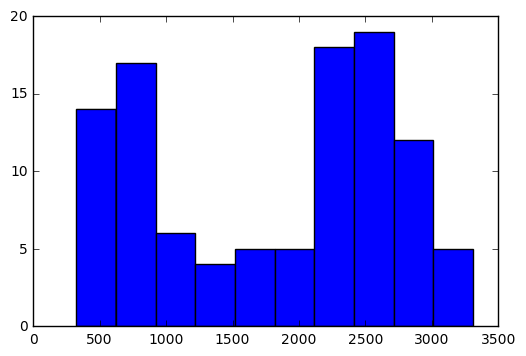

In [271]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(df_hof['G'])
plt.show()

In [272]:
print(df.columns)

Index(['playerID', 'nameFirst', 'nameLast', 'bats', 'throws', 'debut',
       'finalGame', 'Af', 'Gf', 'HBP', 'DPf', 'RBI', 'R', 'CS', 'SBfc', 'IBB',
       'PBfc', '2B', 'AB', 'POf', 'SH', 'CSfc', 'AS_games', 'SO', 'GSf',
       'GIDP', 'H', 'InnOutsf', 'SB', 'BB', 'Years_Played', 'HR', 'G', '3B',
       'WPfc', 'Ef', 'HoF', 'Silver Slugger', 'Gold Glove',
       'Rookie of the Year', 'Most Valuable Player', 'playerIDmstr', 'bats_R',
       'throws_R', 'pos', 'pos__1B', 'pos__2B', 'pos__3B', 'pos__C', 'pos__OF',
       'pos__P', 'pos__SS', 'debutYear', 'finalYear', 'YSR', 'AVE', 'OBP',
       'Slug_Percent', 'OPS', '1993-2009', 'pre1920', '1920-41', '1963-76',
       '1942-45', '1946-62', '1977-92'],
      dtype='object')


In [273]:
numeric_cols = ['Rp', 'SVp', 'RBI', 'BFPp', 'HRp', 'SHOp', 'CSfc', 'SB', 'GSp', 'CS', 'Ef', 'R', 'IPOutsp',
       'PBfc', 'BB', 'SBfc', 'Af', '2B', '3B', 'SO',
       'HR', 'CGp', 'WPfc', 'Lp', 'G', 'IBB',
       'H', 'SOp', 'AB', 'ERp', 'Wp', 'AS_games', 'HoF', 'Gold Glove', 'Rookie of the Year',
       'Silver Slugger', 'Most Valuable Player', 'Cy Young Award', 'bats_R',
       'throws_R','pos__1B', 'pos__2B',
       'pos__3B', 'pos__C', 'pos__OF', 'pos__P', 'pos__SS', 'YSR', 'AVE']

In [274]:
numeric_cols1 = ['Rp', 'SVp', 'GIDP', 'RBI', 'IBBp', 'BFPp', 'InnOutsf',
       'HRp', 'SHOp', 'CSfc', 'SB', 'GSp', 'CS', 'Ef', 'R', 'BKp', 'IPOutsp',
       'WPp', 'PBfc', 'BB', 'SBfc', 'Af', 'HBPp', '2B', '3B', 'SFp', 'SO',
       'HR', 'DPf', 'POf', 'Gf', 'CGp', 'WPfc', 'Lp', 'Gp', 'SH', 'G', 'IBB',
       'H', 'SOp', 'AB', 'ERp', 'Hp', 'GSf', 'SHp', 'HBP', 'BBp', 'GIDPp',
       'Wp', 'GFp', 'AS_games', 'HoF', 'Gold Glove', 'Rookie of the Year',
       'Silver Slugger', 'Most Valuable Player', 'Cy Young Award', 'bats_R',
       'throws_R','pos__1B', 'pos__2B',
       'pos__3B', 'pos__C', 'pos__OF', 'pos__P', 'pos__SS', 'YSR', 'AVE']

In [275]:
num_cols_hitters_w_fielding = ['SB','CS','R','BB','SBfc', 'Af', '2B', '3B','HR',
       'WPfc','G', 'IBB', 'H', 'AB', 'AS_games','Gold Glove', 'Rookie of the Year', 
       'Silver Slugger', 'Most Valuable Player','bats_R',
       'throws_R','pos__1B', 'pos__2B',
       'pos__3B', 'pos__C', 'pos__OF', 'pos__SS', 'YSR', 'AVE', 'HoF', 'pre1920', '1920-41', '1942-45', '1946-62', '1963-76',
       '1977-92', '1993-2009', 'Years_Played', 'OBP', 'Slug_Percent']

In [276]:
num_cols_hitters = ['SB','CS','R','BB', '2B', '3B','HR', 'RBI',
       'G', 'IBB', 'H', 'AB', 'AS_games','Gold Glove', 'Rookie of the Year', 
       'Silver Slugger', 'Most Valuable Player','bats_R',
       'throws_R','pos__1B', 'pos__2B',
       'pos__3B', 'pos__C', 'pos__OF', 'pos__SS', 'YSR', 'AVE', 'HoF', 'pre1920', '1920-41', '1942-45', '1946-62', '1963-76',
       '1977-92', '1993-2009', 'Years_Played', 'OBP', 'Slug_Percent']
data = df_hitters[num_cols_hitters]

In [278]:
print(data.columns)

Index(['SB', 'CS', 'R', 'BB', '2B', '3B', 'HR', 'RBI', 'G', 'IBB', 'H', 'AB',
       'AS_games', 'Gold Glove', 'Rookie of the Year', 'Silver Slugger',
       'Most Valuable Player', 'bats_R', 'throws_R', 'pos__1B', 'pos__2B',
       'pos__3B', 'pos__C', 'pos__OF', 'pos__SS', 'YSR', 'AVE', 'HoF',
       'pre1920', '1920-41', '1942-45', '1946-62', '1963-76', '1977-92',
       '1993-2009', 'Years_Played', 'OBP', 'Slug_Percent'],
      dtype='object')


In [277]:
print(data.isnull().sum(axis=0).tolist())

[430, 3866, 0, 0, 0, 0, 0, 273, 0, 5168, 0, 0, 7223, 7717, 7812, 7791, 7786, 0, 0, 0, 0, 0, 0, 0, 0, 0, 55, 7809, 4826, 6274, 7267, 6575, 6601, 6332, 7242, 0, 50, 55]


In [280]:
print(len(data))

7873


In [281]:
print(data['IBB'])

1         NaN
2         3.0
6         NaN
7         NaN
11        NaN
17        NaN
20        NaN
27        NaN
29       10.0
30        NaN
34        NaN
39        NaN
53        NaN
57       31.0
58        NaN
63        NaN
66        NaN
67        0.0
68        NaN
71        NaN
72        0.0
73        NaN
74        8.0
75        NaN
76        NaN
83        0.0
87        3.0
90        NaN
91        NaN
95        NaN
         ... 
19039     NaN
19042     NaN
19048     3.0
19049     NaN
19050     1.0
19051     NaN
19055     0.0
19058     NaN
19059     NaN
19062     NaN
19065     NaN
19066     NaN
19067     NaN
19068     NaN
19069     NaN
19070     NaN
19071     NaN
19072    12.0
19076     NaN
19080     NaN
19081     NaN
19085     1.0
19086    52.0
19088     NaN
19093     0.0
19095     1.0
19099     3.0
19100     0.0
19101     1.0
19103     NaN
Name: IBB, dtype: float64


In [190]:
data = data.fillna(0)

In [191]:
data_hof = data[data['HoF'] == 1]

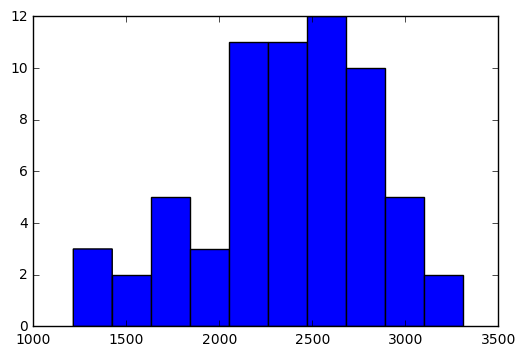

In [192]:
plt.hist(data_hof['G'])
plt.show()

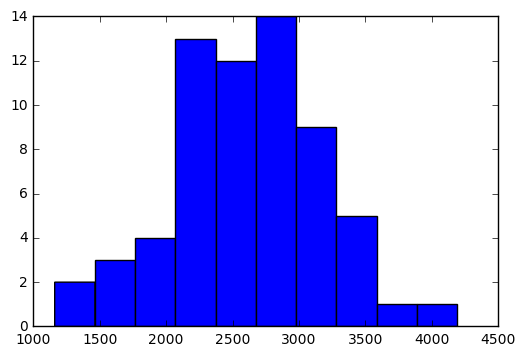

In [193]:
plt.hist(data_hof['H'])
plt.show()

In [194]:
print(data_hof[data_hof['H'] < 1500])

        SB   CS    R    BB   2B  3B   HR     RBI     G  IBB      ...       \
2486  25.0  0.0  627   533  178  18  242   856.0  1215  0.0      ...        
9123  22.0  0.0  971  1011  216  39  369  1015.0  1472  0.0      ...        

      pre1920  1920-41  1942-45  1946-62  1963-76  1977-92  1993-2009  \
2486      0.0      0.0      0.0      1.0      0.0      0.0        0.0   
9123      0.0      0.0      0.0      1.0      0.0      0.0        0.0   

      Years_Played       OBP  Slug_Percent  
2486            10  0.357535      0.499643  
9123            10  0.396075      0.547935  

[2 rows x 38 columns]


In [198]:
print(data_hof[data_hof['G'] < 1500])

          SB    CS     R    BB   2B  3B   HR     RBI     G  IBB      ...       \
2486    25.0   0.0   627   533  178  18  242   856.0  1215  0.0      ...        
3188    64.0  46.0  1041   857  333  64  119   832.0  1482  0.0      ...        
6624    58.0   0.0  1051   852  379  71  331  1276.0  1394  0.0      ...        
9123    22.0   0.0   971  1011  216  39  369  1015.0  1472  0.0      ...        
14627  197.0   0.0   947   740  273  54  137   734.0  1382  0.0      ...        

       pre1920  1920-41  1942-45  1946-62  1963-76  1977-92  1993-2009  \
2486       0.0      0.0      0.0      1.0      0.0      0.0        0.0   
3188       0.0      1.0      0.0      0.0      0.0      0.0        0.0   
6624       0.0      1.0      1.0      1.0      0.0      0.0        0.0   
9123       0.0      0.0      0.0      1.0      0.0      0.0        0.0   
14627      0.0      0.0      0.0      1.0      0.0      0.0        0.0   

       Years_Played       OBP  Slug_Percent  
2486             10  0

In [222]:
print(df.loc[14627])

playerID                          robinja02
nameFirst                            Jackie
nameLast                           Robinson
bats                                      R
throws                                    R
debut                   1947-04-15 00:00:00
finalGame               1956-09-30 00:00:00
Af                                     2728
Gf                                     1364
HBP                                      72
DPf                                     830
RBI                                     734
R                                       947
CS                                      NaN
SBfc                                    NaN
IBB                                     NaN
PBfc                                    NaN
2B                                      273
AB                                     4877
POf                                    4007
SH                                      104
CSfc                                    NaN
AS_games                        

In [199]:
print(data_hof.columns)

Index(['SB', 'CS', 'R', 'BB', '2B', '3B', 'HR', 'RBI', 'G', 'IBB', 'H', 'AB',
       'AS_games', 'Gold Glove', 'Rookie of the Year', 'Silver Slugger',
       'Most Valuable Player', 'bats_R', 'throws_R', 'pos__1B', 'pos__2B',
       'pos__3B', 'pos__C', 'pos__OF', 'pos__SS', 'YSR', 'AVE', 'HoF',
       'pre1920', '1920-41', '1942-45', '1946-62', '1963-76', '1977-92',
       '1993-2009', 'Years_Played', 'OBP', 'Slug_Percent'],
      dtype='object')


In [200]:
print(data_hof['H'].min())

1161


In [201]:
# Split data DataFrame into train and test sets
train = data.sample(frac=0.60, random_state=1)
test = data.loc[~data.index.isin(train.index)]

In [202]:
target = data['HoF']
features = data.drop('HoF', axis=1)

In [203]:
train_target_t = train['HoF']
train_features_t = train.drop('HoF', axis=1)
test_target_t = test['HoF']
test_features_t = test.drop('HoF', axis=1)

In [204]:
print(len(data))

7873


## Don't forget to deal with class imbalance.

In [205]:
from sklearn.cross_validation import cross_val_predict, KFold
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced')
kf = KFold(features.shape[0], random_state=1)

predictions = cross_val_predict(lr, features, target, cv=kf)
predictions = pd.Series(predictions)

In [206]:
tn_filter = (predictions == 0) & (data['HoF'] == 0)
tn = len(predictions[tn_filter])

tp_filter = (predictions == 1) & (data['HoF'] == 1)
tp = len(predictions[tp_filter])

fn_filter = (predictions == 0) & (data['HoF'] == 1)
fn = len(predictions[fn_filter])

fp_filter = (predictions == 1) & (data['HoF'] == 0)
fp = len(predictions[fp_filter])

In [207]:
print(tn)
print(tp)
print(fn)
print(fp)
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
print(fpr)
print(tpr)

3142
1
25
57
0.017818068146295718
0.038461538461538464


In [208]:
len(train_target_t)

4724

In [209]:
lr.fit(train_features_t, train_target_t)
test_predictions = lr.predict(test_features_t)

In [210]:
test_predictions = pd.Series(test_predictions)

tn_filter = (test_predictions == 0) & (test_target_t == 0)
tn = len(test_predictions[tn_filter])

tp_filter = (test_predictions == 1) & (test_target_t == 1)
tp = len(test_predictions[tp_filter])

fn_filter = (test_predictions == 0) & (test_target_t == 1)
fn = len(test_predictions[fn_filter])

fp_filter = (test_predictions == 1) & (test_target_t == 0)
fp = len(test_predictions[fp_filter])

In [211]:
print(tn)
print(tp)
print(fn)
print(fp)
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
print(fpr)
print(tpr)

507
0
3
10
0.019342359767891684
0.0


In [212]:
print(len(target))
print(len(df))
print(len(predictions))

7873
14070
7873


In [213]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1, class_weight='balanced')
predictions = cross_val_predict(rf, features, target, cv=kf)
predictions= pd.Series(predictions)

In [214]:
tn_filter = (predictions == 0) & (data['HoF'] == 0)
tn = len(predictions[tn_filter])

tp_filter = (predictions == 1) & (data['HoF'] == 1)
tp = len(predictions[tp_filter])

fn_filter = (predictions == 0) & (data['HoF'] == 1)
fn = len(predictions[fn_filter])

fp_filter = (predictions == 1) & (data['HoF'] == 0)
fp = len(predictions[fp_filter])

In [215]:
print(tn)
print(tp)
print(fn)
print(fp)

3184
0
26
15


In [216]:
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)

In [217]:
print(fpr)
print(tpr)

0.004688965301656768
0.0
